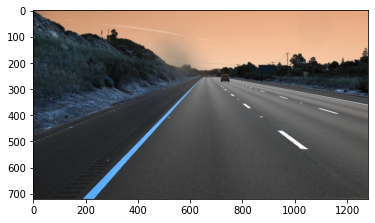

In [ ]:
# import required packages
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
# read each line of json file
json_gt = [json.loads(line) for line in open('/content/train/TUSimple/test_label.json')]
gt = json_gt[0]
gt_lanes = gt['lanes']
y_samples = gt['h_samples']
raw_file = gt['raw_file']
# see the image
#Import image
#Import image
raw_file = cv2.imread('/content/train/TUSimple/test_set/clips/0530/1492626760788443246_0/20.jpg')

#Show the image with matplotlib
plt.imshow(raw_file)
plt.show()

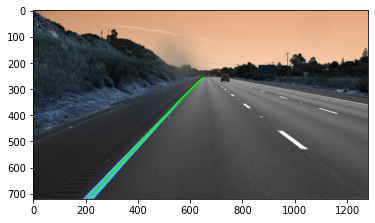

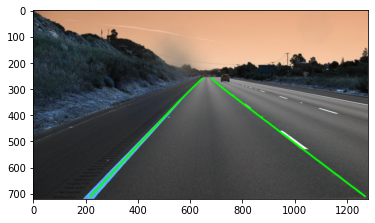

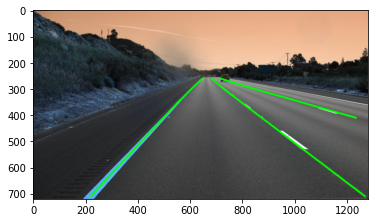

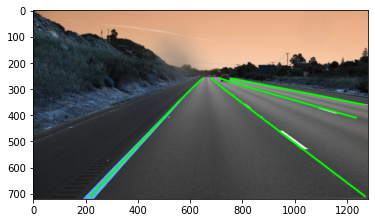

In [ ]:
gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples)
                  if x >= 0] for lane in gt_lanes]
img_vis = raw_file.copy()

for lane in gt_lanes_vis:
  ig =   cv2.polylines(img_vis, np.int32([lane]), isClosed=False,
                   color=(0,255,0), thickness=5)
  plt.imshow(ig)
  plt.show()

In [ ]:
#Generating Labels
#The label should be a grayscale image.
mask = np.zeros_like(raw_file)
colors = [[255,0,0],[0,255,0],[0,0,255],[0,255,255]]
for i in range(len(gt_lanes_vis)):
    ig = cv2.polylines(mask, np.int32([gt_lanes_vis[i]]), isClosed=False,color=colors[i], thickness=5)
# create grey-scale label image
label = np.zeros((720,1280),dtype = np.uint8)
for i in range(len(colors)):
   label[np.where((mask == colors[i]).all(axis = 2))] = i+1

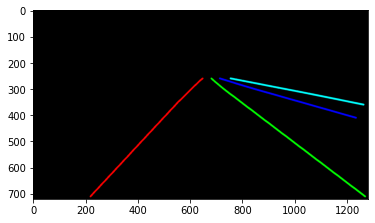

In [ ]:
plt.imshow(ig)
im = plt.show()
im

**Inference Pipeline**

In [ ]:
# ERFNet
# I have choosed erfnet beacuase Efficient Residual Factorized ConvNet for Real-time Semantic Segmentation. 
#Transactions on Intelligent Transportation Systems (T-ITS)

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

#reducing the size of the size with the help of downsampling.
class DownsamplerBlock (nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()

        self.conv = nn.Conv2d(ninput, noutput-ninput, (3, 3), stride=2, padding=1, bias=True)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)

    def forward(self, input):
        output = torch.cat([self.conv(input), self.pool(input)], 1)
        output = self.bn(output)
        return F.relu(output)
    
    #model 

class non_bottleneck_1d (nn.Module):
    def __init__(self, chann, dropprob, dilated):        
        super().__init__()
#Keras Conv2D is a 2D Convolution Layer.
#defining layers
        self.conv3x1_1 = nn.Conv2d(chann, chann, (3, 1), stride=1, padding=(1,0), bias=True)

        self.conv1x3_1 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1), bias=True)

        self.bn1 = nn.BatchNorm2d(chann, eps=1e-03)

        self.conv3x1_2 = nn.Conv2d(chann, chann, (3, 1), stride=1, padding=(1*dilated,0), bias=True, dilation = (dilated,1))

        self.conv1x3_2 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1*dilated), bias=True, dilation = (1, dilated))

        self.bn2 = nn.BatchNorm2d(chann, eps=1e-03)

        self.dropout = nn.Dropout2d(dropprob)
        

    def forward(self, input):

        output = self.conv3x1_1(input)
        output = F.relu(output)
        output = self.conv1x3_1(output)
        output = self.bn1(output)
        output = F.relu(output)

        output = self.conv3x1_2(output)
        output = F.relu(output)
        output = self.conv1x3_2(output)
        output = self.bn2(output)

        if (self.dropout.p != 0):
            output = self.dropout(output)
        
        return F.relu(output+input)    #+input = identity (residual connection)

# encoder is used for one hot encoding
class Encoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.initial_block = DownsamplerBlock(3,16)

        self.layers = nn.ModuleList()

        self.layers.append(DownsamplerBlock(16,64))

        for x in range(0, 5):    #5 times
           self.layers.append(non_bottleneck_1d(64, 0.03, 1)) 

        self.layers.append(DownsamplerBlock(64,128))

        for x in range(0, 2):    #2 times
            self.layers.append(non_bottleneck_1d(128, 0.3, 2))
            self.layers.append(non_bottleneck_1d(128, 0.3, 4))
            self.layers.append(non_bottleneck_1d(128, 0.3, 8))
            self.layers.append(non_bottleneck_1d(128, 0.3, 16))

        #Only in encoder mode:
        self.output_conv = nn.Conv2d(128, num_classes, 1, stride=1, padding=0, bias=True)

    def forward(self, input, predict=False):
        output = self.initial_block(input)

        for layer in self.layers:
            output = layer(output)

        if predict:
            output = self.output_conv(output)

        return output


class UpsamplerBlock (nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ninput, noutput, 3, stride=2, padding=1, output_padding=1, bias=True)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        return F.relu(output)
#This method is used to convert from one encoding scheme in which argument string is encoded to the desired encoding scheme. This works opposite to the encode.
class Decoder (nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(UpsamplerBlock(128,64))
        self.layers.append(non_bottleneck_1d(64, 0, 1))
        self.layers.append(non_bottleneck_1d(64, 0, 1))

        self.layers.append(UpsamplerBlock(64,16))
        self.layers.append(non_bottleneck_1d(16, 0, 1))
        self.layers.append(non_bottleneck_1d(16, 0, 1))

        self.output_conv = nn.ConvTranspose2d( 16, num_classes, 2, stride=2, padding=0, output_padding=0, bias=True)

    def forward(self, input):
        output = input

        for layer in self.layers:
            output = layer(output)

        output = self.output_conv(output)

        return output

#ERFNet
class Net(nn.Module):
    def __init__(self, num_classes, encoder=None):  #use encoder to pass pretrained encoder
        super().__init__()

        if (encoder == None):
            self.encoder = Encoder(num_classes)
        else:
            self.encoder = encoder
        self.decoder = Decoder(num_classes)

    def forward(self, input, only_encode=False):
        if only_encode:
            return self.encoder.forward(input, predict=True)
        else:
            output = self.encoder(input)    #predict=False by default
            return self.decoder.forward(output)

In [ ]:
# using pytorch
import cv2
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
#this function would define the lane colours,width,height of the image
def color_lanes(image, classes, i, color, HEIGHT, WIDTH):
    buffer_c1 = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    buffer_c1[classes == i] = color[0]
    image[:, :, 0] += buffer_c1
    buffer_c2 = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    buffer_c2[classes == i] = color[1]
    image[:, :, 1] += buffer_c2
    buffer_c3 = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    buffer_c3[classes == i] = color[2]
    image[:, :, 2] += buffer_c3
    return image
img = cv2.imread('/content/train/TUSimple/test_set/clips/0530/1492626613875984115_0/10.jpg') 

op_transforms = transforms.Compose([transforms.ToTensor()])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
im_tensor = torch.unsqueeze(op_transforms(img), dim=0)
im_tensor = im_tensor.to(device)
model = Net(5)
model = model.to(device)
model = model.eval()
out = model(im_tensor)
out = out.max(dim=1)[1]
out_np = out.cpu().numpy()[0]
out_viz = np.zeros((20, 20, 3))


Model Evaluations

actual image


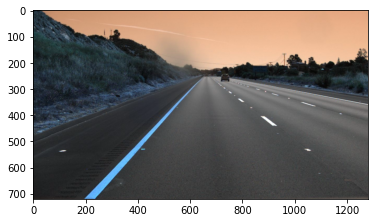

lane detected


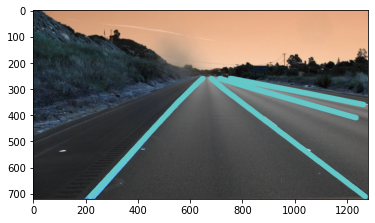

In [26]:
print("actual image")
image = cv2.imread('/content/train/TUSimple/test_set/clips/0530/1492626760788443246_0/1.jpg')
plt.imshow(image)
plt.show()


print("lane detected")
predict = cv2.imread('/content/train/TUSimple/test_set/clips/0530/1492626760788443246_0/1.jpg')

for lane in gt_lanes_vis:
    predict =   cv2.polylines(predict, np.int32([lane]), isClosed=False,
                   color=(100, 200, 200), thickness=20)
plt.imshow(predict)
plt.show()